# Retrain and analysis for DER++ on Split-CIFAR100

In this notebook we retrain the DER++, Naive and Replay models with best found hyperparams on the entire Split-CIFAR100 training stream.

## Imports

In [3]:
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

import torch
from torchvision.transforms import Compose, Normalize, ToTensor

from avalanche.benchmarks.classic import SplitCIFAR100

/home/giacomo/mambaforge/envs/continual/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

We use the same 10 experiences with 10 new classes each.

We are in a Class-Incremental setting, without task labels.

In [2]:
num_experiences = 10

In [3]:
# No transformations because they are included in the DER plugin
split_cifar100 = SplitCIFAR100(n_experiences=num_experiences, seed=42, train_transform=Compose([ToTensor(), Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))]))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(len(split_cifar100.train_stream[0].dataset))
print(len(split_cifar100.test_stream[0].dataset))

5000
1000


In [5]:
# With transformations for Naive and Replay training
split_cifar100_transform = SplitCIFAR100(n_experiences=num_experiences, seed=42)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(len(split_cifar100_transform.train_stream[0].dataset))
print(len(split_cifar100_transform.test_stream[0].dataset))

5000
1000


# Retrain models

In [7]:
from torchvision.models import resnet18
from torch.nn import CrossEntropyLoss
from avalanche.training import Naive, Replay

In [8]:
if torch.cuda.is_available():       
        device = torch.device("cuda")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [9]:
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, forgetting_metrics, bwt_metrics
from avalanche.logging import InteractiveLogger, TensorboardLogger

In [6]:
save_folder = './results/SCIFAR100'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

## Retrain DER++

In [11]:
from der import DerPlugin

In [12]:
# Params

best_lr = 0.1
best_alpha = 0.2
best_beta = 1.0

mem_size = 500
epochs = 50
batch_size = 32

In [13]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(trained_experience=True, stream=True, epoch_running=True),
    loss_metrics(stream=True, epoch_running=True),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger(), TensorboardLogger(os.path.join(save_folder, 'der_retrain_tb'))],
    strict_checks=True
)

In [14]:
# Create model, optimizer and criterion
model = resnet18(weights=None, num_classes=100)
optimizer = torch.optim.SGD(model.parameters(), lr=best_lr)
criterion = CrossEntropyLoss()
# Initialize DER plugin
der_plugin = DerPlugin(mem_size=mem_size, alpha=best_alpha, beta=best_beta)
# Initialize CL strategy
cl_strategy = Naive(model, optimizer, criterion, train_mb_size=batch_size, train_epochs=epochs, eval_mb_size=batch_size,
                    eval_every=0, device=device, evaluator=eval_plugin, plugins=[der_plugin])

exp_results = []

# TRAINING LOOP WITH TEST AT EACH EXPERIENCE
print('Starting experiment...')
results = []
for experience in split_cifar100.train_stream:
    cl_strategy.train(experience)

    exp_results.append(cl_strategy.eval(split_cifar100.test_stream))

Starting experiment...
-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 157/157 [00:03<00:00, 50.93it/s] 
> Eval on experience 0 (Task 0) from train stream ended.
-- >> End of eval phase << --
	Accuracy_On_Trained_Experiences/eval_phase/train_stream/Task000 = 0.0000
	Loss_Stream/eval_phase/train_stream/Task000 = 4.7003
	StreamBWT/eval_phase/train_stream = 0.0000
	StreamForgetting/eval_phase/train_stream = 0.0000
	Top1_Acc_Stream/eval_phase/train_stream/Task000 = 0.0000
100%|██████████| 157/157 [00:02<00:00, 56.14it/s]
Epoch 0 ended.
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 4.8120
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.4004
100%|██████████| 157/157 [00:02<00:00, 66.67it/s]
Epoch 1 ended.
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 2.7513
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.5558
100%|██████████| 157/157 [00:02<00:00, 65.98i

Save results

In [15]:
aggregated_results = {}

# Aggregate experiencess results by metric
for i, exp_dict in enumerate(exp_results):
    for metric_name, metric_value in exp_dict.items():
            if metric_name not in aggregated_results:
                aggregated_results[metric_name] = []
                aggregated_results[metric_name].append(metric_value)
            else:
                aggregated_results[metric_name].append(metric_value)

# Save results to csv
save_pth = os.path.join(save_folder, 'der_retrain.csv')
for metric_name, metric_values in aggregated_results.items():
    # write row to csv
    with open(save_pth, 'a') as f:
        f.write(f'{metric_name},')
        for value in metric_values:
            f.write(f'{value},')
        f.write('\n')

## Retrain Naive

In [11]:
# Params

best_lr = 0.03

mem_size = 500
epochs = 50
batch_size = 32

In [12]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(trained_experience=True, stream=True, epoch_running=True),
    loss_metrics(stream=True, epoch_running=True),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    loggers=[TensorboardLogger(os.path.join(save_folder, 'naive_retrain_tb'))],
    strict_checks=True
)

In [13]:
# Create model, optimizer and criterion
model = resnet18(weights=None, num_classes=100)
optimizer = torch.optim.SGD(model.parameters(), lr=best_lr)
criterion = CrossEntropyLoss()
# Initialize CL strategy
cl_strategy = Naive(model, optimizer, criterion, train_mb_size=batch_size, train_epochs=epochs, eval_mb_size=batch_size,
                    eval_every=0, device=device, evaluator=eval_plugin)

exp_results = []

# TRAINING LOOP WITH TEST AT EACH EXPERIENCE
print('Starting experiment...')
results = []
for experience in tqdm(split_cifar100_transform.train_stream):
    cl_strategy.train(experience)

    exp_results.append(cl_strategy.eval(split_cifar100_transform.test_stream))

Starting experiment...


100%|██████████| 10/10 [47:11<00:00, 283.13s/it]


Save results

In [14]:
aggregated_results = {}

# Aggregate experiencess results by metric
for i, exp_dict in enumerate(exp_results):
    for metric_name, metric_value in exp_dict.items():
            if metric_name not in aggregated_results:
                aggregated_results[metric_name] = []
                aggregated_results[metric_name].append(metric_value)
            else:
                aggregated_results[metric_name].append(metric_value)

# Save results to csv
save_pth = os.path.join(save_folder, 'naive_retrain.csv')
for metric_name, metric_values in aggregated_results.items():
    # write row to csv
    with open(save_pth, 'a') as f:
        f.write(f'{metric_name},')
        for value in metric_values:
            f.write(f'{value},')
        f.write('\n')

## Retrain Replay

In [15]:
# Params

best_lr = 0.03

mem_size = 500
epochs = 50
batch_size = 32

In [16]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(trained_experience=True, stream=True, epoch_running=True),
    loss_metrics(stream=True, epoch_running=True),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    loggers=[TensorboardLogger(os.path.join(save_folder, './replay_retrain_tb'))],
    strict_checks=True
)

In [17]:
# Create model, optimizer and criterion
model = resnet18(weights=None, num_classes=100)
optimizer = torch.optim.SGD(model.parameters(), lr=best_lr)
criterion = CrossEntropyLoss()
# Initialize CL strategy
cl_strategy = Replay(model, optimizer, criterion, mem_size=mem_size, train_mb_size=batch_size, train_epochs=epochs, eval_mb_size=batch_size,
                    eval_every=0, device=device, evaluator=eval_plugin)

exp_results = []

# TRAINING LOOP WITH TEST AT EACH EXPERIENCE
print('Starting experiment...')
results = []
for experience in tqdm(split_cifar100_transform.train_stream):
    cl_strategy.train(experience)

    exp_results.append(cl_strategy.eval(split_cifar100_transform.test_stream))

Starting experiment...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [1:03:51<00:00, 383.19s/it]


Save results

In [18]:
aggregated_results = {}

# Aggregate experiencess results by metric
for i, exp_dict in enumerate(exp_results):
    for metric_name, metric_value in exp_dict.items():
            if metric_name not in aggregated_results:
                aggregated_results[metric_name] = []
                aggregated_results[metric_name].append(metric_value)
            else:
                aggregated_results[metric_name].append(metric_value)

# Save results to csv
save_pth = os.path.join(save_folder, 'replay_retrain.csv')
for metric_name, metric_values in aggregated_results.items():
    # write row to csv
    with open(save_pth, 'a') as f:
        f.write(f'{metric_name},')
        for value in metric_values:
            f.write(f'{value},')
        f.write('\n')

## Final Analysis

In [4]:
import glob
import pandas as pd

In [7]:
retrain_files = glob.glob(os.path.join(save_folder, '*_retrain.csv'))

# Save accuracies after trained experience for each experience of the grid search runs.
# In the dict the key is the grid search run, while the value is a list of accuracies after each experience
acc_trained_exps_dict = {}

for file in retrain_files:
    df = pd.read_csv(file, index_col=None, header=None)
    acc_trained_exps = df[df[0].str.startswith('Accuracy_On_Trained_Experiences/eval_phase/test_stream/Task000')].values[0][1:-1]
    # Get the model name from the file name
    model_name = file.split('/')[-1].split('_')[0]
    acc_trained_exps_dict[model_name] = acc_trained_exps


Plot accuracy over trained experiences for all models.

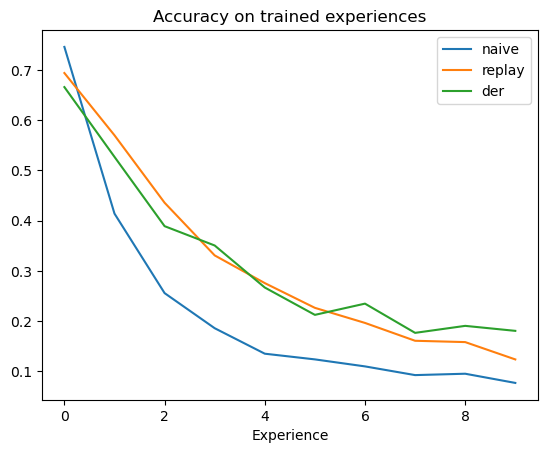

In [8]:
for model_name, acc_trained_exps in acc_trained_exps_dict.items():
    plt.plot(acc_trained_exps, label=model_name)
    plt.legend()
    plt.title('Accuracy on trained experiences')
    plt.xlabel('Experience')
plt.show()

Calculate **Final Average Accuracy** for all models.

In [9]:
for model_name, acc_trained_exps in acc_trained_exps_dict.items():
    print(f'{model_name}: {acc_trained_exps[-1]}')

naive: 0.0768
replay: 0.1236
der: 0.1805


Calculate **Incremental Average Accuracy** for all models.    

In [10]:
for model_name, acc_trained_exps in acc_trained_exps_dict.items():
    print(f'{model_name}: {acc_trained_exps.mean()}')

naive: 0.223408373015873
replay: 0.3171096825396825
der: 0.31937920634920636


More plots on Tensorboard.